## Introduction

For this project, I am going to attempt to predict the price of Bitcoin. The data I am using is taken from coindesk which offers a REST API allowing me to obtain a dataset showing daily Bitcoin price in USD. 

### A bit about Bitcoin...

Bitcoin was launched in 2009 and is generally considered the most prominient cryptocurrency although does have some strong competetors. Throughout its life, Bitcoin has been extremely volatile in value, experiencing huge inflation and subsequent crashes. 

Bitcoin is based on a blockchain,  a public ledger containing all  transactions in the bitcoin network. This eliminates the need for any central authority and enables transaction to take place without trust between the two parties. Users can mine for bitcoins by solving problems using compute power that make the network secure. The compute cost of mining bitcoin is extremely high, requiring specialised equipment. 

The are many factors which can impact the price of Bitcoin, and given its relatively short lifespan its difficult to tell how large financial or market events could impact it. Like all currency, supply and demand is a key factor. Given the high electricity requirements to produce Bitcoin, increased energy costs can mean that the production of bitcoin slows and reduces supply (increasing the price). The total number of bitcoins that can ever be in existance is 21 million. The supply of bitcoin reached 18.1 million in December 2019, representing 86.2% of the supply of bitcoin that will ever be  available. Once 21 million bitcoins are in circulation, prices depend on whether it is considered practical (readily usable in transactions), legal, and in demand. This means that any regulation of bitcoin could have a big impact. Finally, bitcoin has an inbuilt mechanism that acts like an artifical inflator, called halving. Halving occurs rughly every 4 years, where the reward that miners recive for their activity is halved. This reduces the number of coins available, having an inflatory effect on the price.

### Time series forecasting the Bitcoin price

A time series is a sequence where a data point <b>obs(t)</b> is recorded over regular time intervals <b>t</b>. It is a descriptive analysis of how <b>obs(t)</b>  changes with <b>t</b>. A tme series forecast is a predictive analysis of the data, forecasting future <b>obs(t)</b> at <b>t + n</b>.

A time series consists of 4 elements:

-level: average over time<br>
-trend: increase/decrease over time<br>
-seasonality: cycles repeated in the data, for example related to time of year<br>
-noise: random variation

We can use a decompostion model to analysis these elements in the data (see XXX)

To predict the future price of Bitcoin, I will use an ARIMA model (Auto Regressive Integrated Moving Average). This model aims to predict future values based on lags <b>t-n</b>, and it can be used to forecast non seasonal time series data. The ARIMA model used 3 parameters:

<b>p</b>, the auto regressive (AR) term, predicts future values based on past values by identifying correlation between previous values. p represents the order of lagged values. If <b>p</b> = 1, then the outcome value is t-1.

<b>q</b>, the moving average (MA) term, models the next value in the sequence as a linear function of residual errors from a previous mean.

<b>d</b>, the differencing required to remove the trend from the data to make it stationary (mean and standard deviation stays the same).




## Getting The Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests
from datetime import datetime, timedelta, date
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm_notebook
from itertools import product
#import statistics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Get data and remove the columns we dont need

today = str(date.today())
response =requests.get(' https://api.coindesk.com/v1/bpi/historical/close.json?start=2016-08-01&end=' + today).json()
df = pd.DataFrame.from_dict(response)
df = df.drop(['disclaimer','time'], axis = 1).dropna()
display(df)

,bpi
2016-08-01,607.3740
2016-08-02,552.8210
2016-08-03,565.2638
2016-08-04,578.3213
2016-08-05,574.9563
...,...
2020-12-04,18657.4200
2020-12-05,19157.9250
2020-12-06,19386.7117
2020-12-07,19185.3967


## Exploring The Data

In [3]:
df.describe()

,bpi
count,1591.000000
mean,6624.034241
std,4092.807697
min,552.821000
25%,3540.177500
50%,6778.610000
75%,9334.115000
max,19708.096700


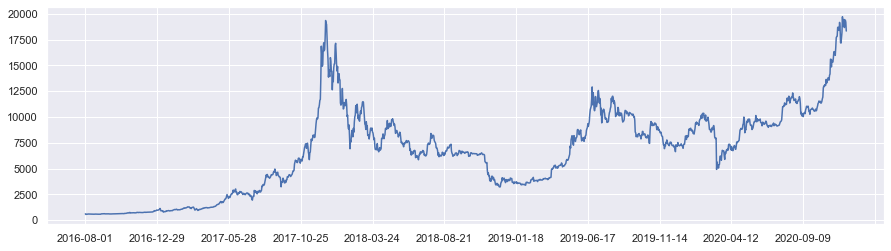

In [4]:
#Plot the data to see the trend over time
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
lines = ax.plot(df.bpi)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

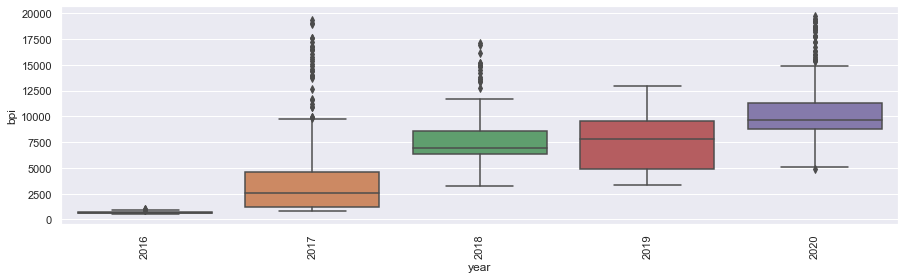

In [5]:
#investigate the variance each year
df['year'] = pd.DatetimeIndex(df.index).year

fig, axes = plt.subplots(figsize=(15, 4))
ax = sns.boxplot(data = df, x='year',y=('bpi'))
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

df = df.drop(['year'], axis = 1)

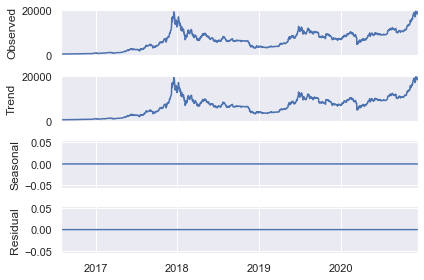

In [6]:
df.index = pd.to_datetime(df.index)
decom = seasonal_decompose(df, model = 'additive', freq = 1)
decom.plot()
plt.show()

## Check If The Data Is Stationary

In order to use ARIMA, the data I am working with must be stationary. As ARIMA is a linear regression model, it will perform best when the predictors are not correlated. I can see from the above decomposition model that the data has no seasonality or residuals, but there is a trend elemtns to the data so it is not stationary.

To double check this, I will use the Augmented Dickey Fuller test. For this test, the null hypothesis is that the data is non stationary and the alternative hypothesis is that the data is stationary. In order to reject the null hypothesis, the p-value should be < 5%, (e.g. a 95%) confidence rate.


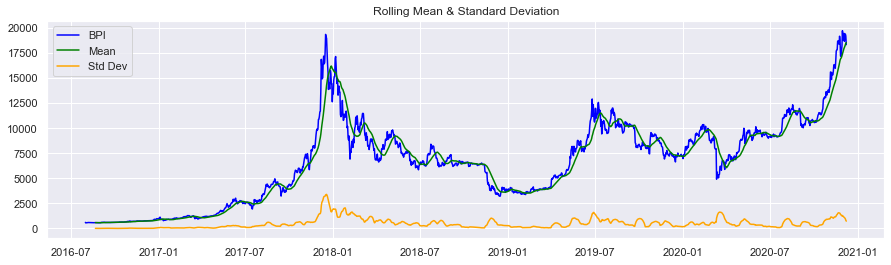

ADF Stat: -1.369936
P-value: 0.596601
The graph is non stationary


In [7]:
#Testing if the data is stationary
from statsmodels.tsa.stattools import adfuller

def test_stationary(x):
    
    #Get rolling stats
    rollingmean = x.rolling(window = 22, center=False).mean()
    rollingstd = x.rolling(window = 22, center=False).std()
    
    #Plot rolling stats
    plt.figure(figsize=(15, 4))
    orig = plt.plot(x, color = 'blue', label = 'BPI')
    mean = plt.plot(rollingmean, color = 'green', label = "Mean")
    std = plt.plot(rollingstd, color = 'orange', label = 'Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    #Dickey Fuller Test
    result=adfuller(x)
    print('ADF Stat: %F'%result[0])
    print('P-value: %F'%result[1])
    pvalue = result[1]
    for key, value in result[4].items():
        if result[0]>value:
            print ('The graph is non stationary')
            break
        else:
            print('The graph is stationary')
            break;
        print('Critical values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

data = df['bpi']
test_stationary(data)

## Differencing

As the data is non stationary, I will need to use differencing to remove the trend. the ARIMA parameter <b>d</b> defines the number of differencing steps.


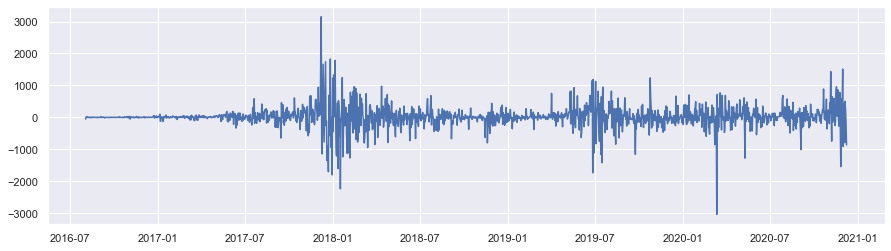

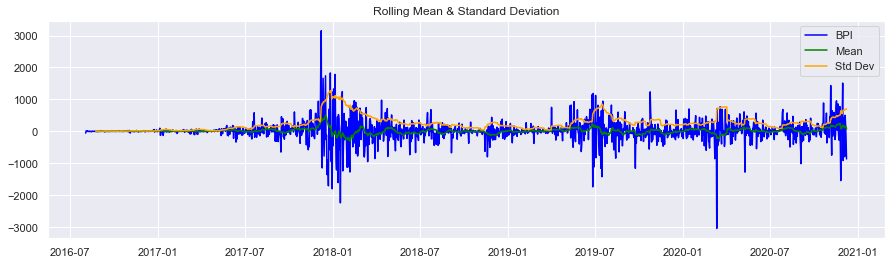

ADF Stat: -7.594301
P-value: 0.000000
The graph is stationary


In [8]:
#Difference the data

data_diff = data.diff()

plt.figure(figsize=(15, 4))
plt.plot(data_diff)
plt.show()

data_diff.dropna(inplace = True)
test_stationary(data_diff)

## Setting model parameters

The above steps have determined that parameter <b>d</b> should be 1. 

To set the model parameters <b>p</b> and <b>q</b> I will plot an Autocorrelation Function (ACF) and a Partial Autocorrelation Function (PACF). 

ACF shows the correlation between lags and can be used to determine the value of <b>q</b> by seeing how many lags go beyond the significance region (blue area) in the plot.

PACF finds correlations between residuals and can be used to determine the value of <b>p</b> by seeing how many residuals go beyond the significance region (blue area) in the plot.


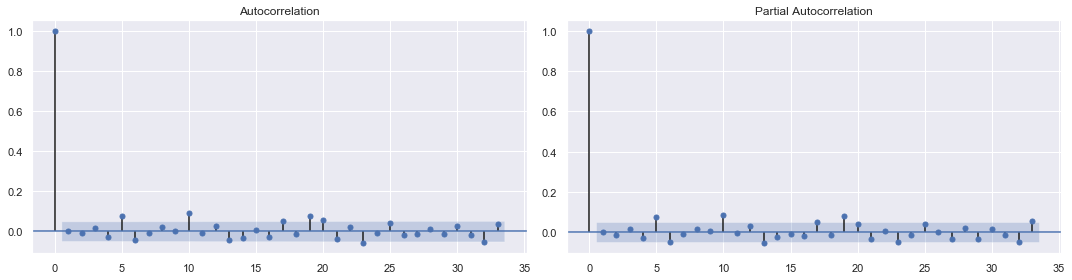

In [9]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,4))

ax = plt.subplot(121)
plot_acf(data_diff, ax=ax)

ax = plt.subplot(122)
plot_pacf(data_diff, ax=ax)

plt.tight_layout()
plt.show()

## Model

As the data is a time series, we cannot split the test and train data randomly so I will use the first 80% of observations for the training set and the remaining 20% for testing.

The model summary will help me to assess the success of the model. The AIC (Akaike information criterion) estimates the amount of information lost by the model, so a lower number is better.

In [26]:
#Create train and test datasets
data_diff.dropna(inplace = True)
size = int(len(data)*0.8)
train, test = data[0:size], data[size:len(data)]

# build model
history = train.tolist()
predictions = list()
error_list = list()
originals = list()

model = ARIMA(history, order=(4, 2, 4))
model_fit = model.fit(disp=0)
    
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1270
Model:                 ARIMA(4, 2, 4)   Log Likelihood               -9178.242
Method:                       css-mle   S.D. of innovations            332.016
Date:                Wed, 09 Dec 2020   AIC                          18376.484
Time:                        17:28:19   BIC                          18427.952
Sample:                             2   HQIC                         18395.818
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0086      0.027     -0.318      0.750      -0.061       0.044
ar.L1.D2.y    -2.2637      0.292     -7.741      0.000      -2.837      -1.691
ar.L2.D2.y    -1.8245      0.498     -3.667      0.0

<function matplotlib.pyplot.show(*args, **kw)>

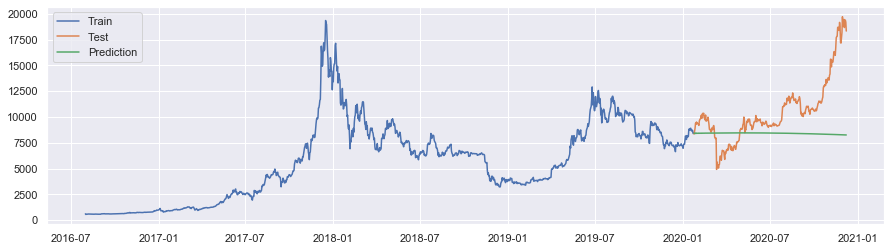

In [27]:
forecast = model_fit.forecast(steps = len(test))[0]
forecast = pd.DataFrame(forecast, index = test.index, columns = ['predictions'])

fig = plt.figure(figsize=(15, 4))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(forecast, label = 'Prediction')
plt.legend(loc = 'upper left')
plt.show

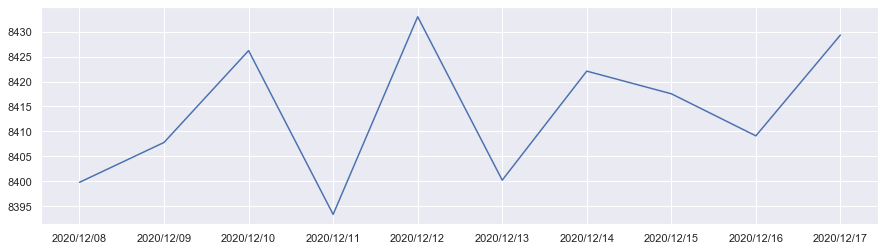

In [28]:
days = 10
dates = []

for i in range(days):
    lastdate = max(df.index)
    newdate = lastdate + timedelta(days=i)
    newdate = datetime.strftime(newdate, "%Y/%m/%d")
    dates.append(newdate)
    i = i +1
    
forward = model_fit.forecast(days)
dct = dict(zip(dates, forward[0]))
forecast = pd.DataFrame.from_dict(dct, orient='index',columns=['Prediction'])

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
line = ax.plot(forecast)
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

### Conclusion